# Calculate the apparent attenuation rate from ACCESS-OM3



In [3]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
# esm_file = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"
esm_file = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_nomixing/experiment_datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_nomixing/experiment_datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-paper-figs/


In [4]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

In [8]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

ERROR! Session/line number was not unique in database. History logging moved to new session 3443


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36773 instead
  warnings.warn(


/proxy/36773/status


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-514552' coro=<Client._gather.<locals>.wait() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit
2025-11-27 17:20:59,129 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:33575' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('array-3612d2b4b3a8add17f9673f7f951e44d', 0)} (stimulus_id='handle-worker-cleanup-1764224459.1296122')
2025-11-27 17:20:59,240 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:45155' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('getitem-a54420b97

### Open the intake-esm datastore

In [9]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [10]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [11]:
datastore_filtered = datastore.search(realm="wave", frequency="fx")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
EF,1D spectral density,,,m2 s
FP0,Peak frequency,,,s-1
HS,Significant wave height,,,m
ICE,Ice coverage,,,nd
ICEF,Ice floe diameter,,,m
ICEH,Ice thickness,,,m
T01,"Mean wave period (Tm0,1)",,,s
T02,"Mean wave period (Tm0,2)",,,s
T0M1,"Mean wave period (Tm0,-1)",,,s


### Load frequency spectrum, mean wave statistics, and ice concentration

In [12]:
ds = datastore.search(variable=["EF", "ICE", "HS", "MWD", "FP0"], frequency="fx").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"ny": -1, "nx": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
ds_grid = datastore.search(variable=["TLON", "TLAT", "HTE"], frequency="fx", realm="seaIce").to_dask().compute()
ds_grid = ds_grid.rename({'ni': 'nx', 'nj': 'ny'})
# ds_grid

ds = xr.merge([ds, ds_grid])
ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 4GB
Dimensions:  (time: 365, ny: 300, nx: 360, freq: 25)
Coordinates:
  * time     (time) object 3kB 1900-01-02 00:00:00 ... 1901-12-01 00:00:00
    TLAT     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    TLON     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ULON     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ULAT     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    NLON     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    NLAT     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ELON     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ELAT     (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: ny, nx, freq
Data variables:
    HS       (time, ny, nx) float32 158MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    EF       (time, freq, ny, nx) float32 4GB dask.array<chunksize=(1, 25, 300, 360), meta=np.ndarray>
    ICE      (time, ny, nx) float32 158MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    FP0      (time, ny, nx) float32 158MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    HTE      (ny, nx) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    intake_esm_vars:                          ['HS', 'EF', 'ICE', 'FP0']
    intake_esm_attrs:file_id:                 access_om3_ww3_hi_XXXX_XX_XX_XXXXX
    intake_esm_attrs:frequency:               fx
    intake_esm_attrs:variable:                mapsta,UAX,UAY,ICE,ICEH,ICEF,HS...
    intake_esm_attrs:variable_long_name:      map status,Mean wind, x-compone...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_units:          unitless,m s-1,m s-1,nd,m,m,m,s...
    intake_esm_attrs:realm:                   wave
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_ww3_hi_XXXX_XX_XX_XX...

### Plot along a transect

In [14]:
# ds_transect

In [15]:
# ds_transect['TLAT']

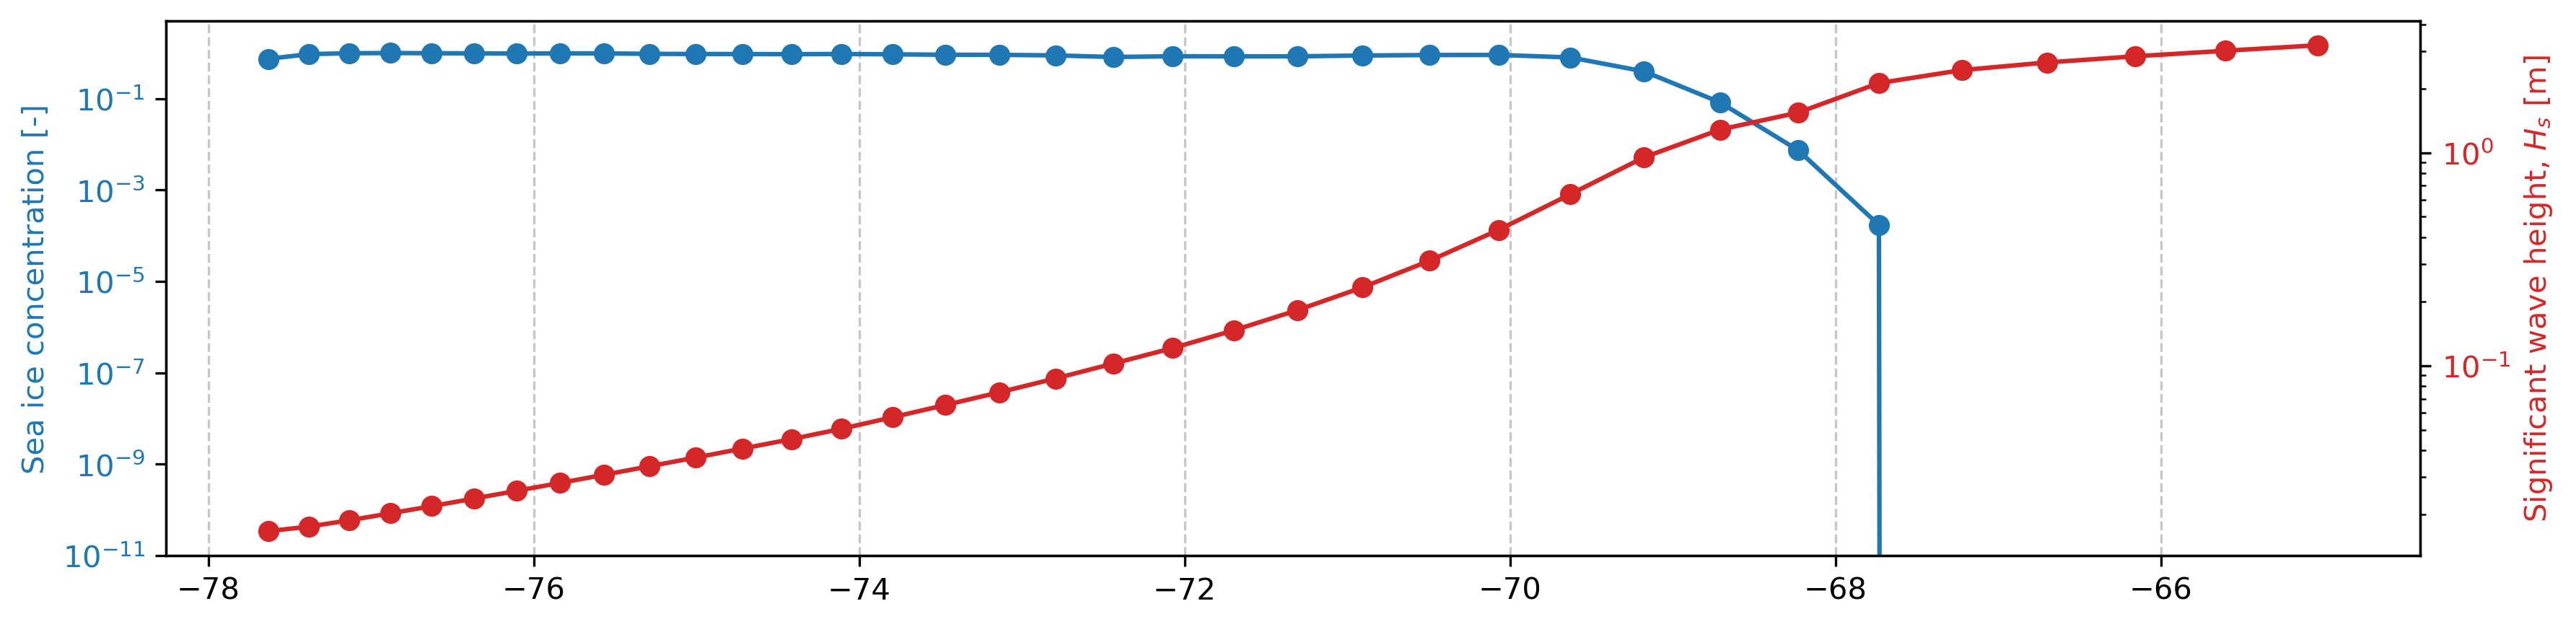

In [17]:
nx_idx = 100
# ny_slice = slice(0,50)
time_idx = 100
PUNY = 1e-11

fig, ax1 = plt.subplots(1,1, figsize=(12,3))

# Extract transect
ds_transect = ds.isel(time=time_idx, nx=nx_idx)
ds_transect = ds_transect.where(ds_transect['TLAT'] < -65)
# Use latitude for x-axis
x_vals = ds_transect["TLAT"].values

# First variable: ICE
ax1.plot(x_vals, ds_transect["ICE"].values, color="tab:blue", label="ICE", marker='o')
ax1.set_ylabel("Sea ice concentration [-]", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(PUNY, 5)
ax1.set_yscale('log')

# Second variable: HS (on twin axis)
ax2 = ax1.twinx()
ax2.plot(x_vals, ds_transect["HS"].values, color="tab:red", label="HS", marker='o')
ax2.set_ylabel("Significant wave height, $H_s$ [m]", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_yscale('log')

# Grid lines
ax1.grid(True, which="both", axis="x", linestyle="--", alpha=0.7)

# Mark ice edges
# ax1.axvline(ds_transect["lat"].values[ice_edge_idx], color='gray', linestyle='-')
# ax1.axvline(ds_transect["TLAT"].values[p01_ice_edge_idx], color='gray', linestyle='--')
# ax1.axvline(ds_transect["TLAT"].values[puny_ice_edge_idx], color='gray', linestyle=':')

# ax1.set_xlim([x_vals.min(), -50])

plt.tight_layout()
plt.show()

### Calculate the apparent attenuation rate
We calculate the empirical attenuation rate by completing a log regression
$$
    \frac{1}{a_{\text{ice}}} \log \left( \frac{S_{\text{ice}} (x; f)}{S_0(x; f)} \right) \sim -\alpha_a  x
$$ which returns the *apparent attenuation*, $\alpha_a$, over distance, $x$.

NB. We assume that waves propagate with the index ny

In [76]:
def get_ww3_freqs(nk=25):
    """
    Generate WW3 frequency bins and corresponding periods.
    
    Parameters
    ----------
    nk : float
        Number of wave numbers/frequency bins.
    """
    f1 = 0.04118   # lowest frequency [Hz]
    xfr = 1.1      # frequency growth factor
    
    freqs = f1 * xfr**np.arange(nk)
    periods = 1.0 / freqs
    return freqs, periods

freqs, periods = get_ww3_freqs(nk=25)

In [19]:
ds_waves_in_ice = ds_transect.where(ds_transect['ICE'] > PUNY)
distance_into_ice = abs((ds_waves_in_ice['TLAT'] - ds_waves_in_ice['TLAT'].max())*111*1e3) # Degrees latitude to m


In [78]:
import numpy as np
import statsmodels.api as sm

def fit_log_ols(ds_in, distance_from_edge, freq, ax=None):
    """
    Perform OLS: log(S_norm) = beta0 + beta1 * x
    Returns (intercept, alpha), where alpha = -beta1
    """
    # Extract data
    x = distance_from_edge.values
    S = ds_in['EF'].sel(freq=freq).values
    S_norm = S / S[-1]
    y = np.log(S_norm)
    # print(S)
    # Mask invalid values
    # mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (S > 1e-12)
    # x = x[mask]
    # y = y[mask]
    # print(y)

    if len(x) < 2:
        return None, None

    # Keep only first 5 points
    # x = x[:5]
    # y = y[:5]

    # Shift x for stability
    x = x - x.min()

    # OLS
    X = sm.add_constant(x)
    # model = sm.OLS(y, X).fit()
    # beta0, beta1 = model.params
    beta0, beta1 = 0, 1e5
    # Convert slope -> attenuation rate
    alpha = -beta1

    # Plot
    if ax is not None:
        ax.scatter(x, y, s=12)
        ax.plot(x, model.predict(X), lw=1.5, color='red')
        ax.set_title(f"Freq = {float(freq):.3f} Hz")
        ax.set_xlabel("Distance [m]")
        ax.set_ylabel("log(E)")
        ax.legend([f"β0={beta0:.2e}, α={alpha:.2e}"], fontsize=7)

    return beta0, alpha

In [ ]:
freqs = ds_waves_in_ice.freq.values
n = len(freqs)

fig, axes = plt.subplots(
    int(np.ceil(n/4)), 4,
    figsize=(16, 3*np.ceil(n/4)),
    constrained_layout=True
)
axes = axes.flatten()

alphas = []
intercepts = []

for i, freq in enumerate(freqs):
    b0, a = fit_log_ols(ds_waves_in_ice, distance_into_ice, freq, ax=axes[i])
    intercepts.append(b0)
    alphas.append(a)

# Turn off extra axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.show()

In [74]:
# alphas

### Look at the distribution of waves in ice

In [49]:
# mask = (~np.isnan(ds_transect['EF'])).compute()
# ds_waves_in_ice = ds_transect.sel(ny=mask)
ds_waves_in_ice

<xarray.Dataset> Size: 55kB
Dimensions:  (ny: 300, freq: 25)
Coordinates:
    time     object 8B 1900-07-11 00:00:00
    TLAT     (ny) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 87.41 87.57 87.66
    TLON     (ny) float64 2kB 180.5 180.5 180.5 180.5 ... 234.5 244.0 254.5
    ULON     (ny) float64 2kB -179.0 -179.0 -179.0 ... -120.0 -110.3 -100.0
    ULAT     (ny) float64 2kB -77.75 -77.51 -77.26 -77.01 ... 87.39 87.51 87.55
    NLON     (ny) float64 2kB -179.5 -179.5 -179.5 ... -120.9 -110.8 -280.0
    NLAT     (ny) float64 2kB -77.75 -77.51 -77.26 -77.01 ... 87.5 87.62 65.21
    ELON     (ny) float64 2kB -179.0 -179.0 -179.0 ... -124.5 -115.3 -105.2
    ELAT     (ny) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 87.31 87.46 87.54
Dimensions without coordinates: ny, freq
Data variables:
    HS       (ny) float32 1kB dask.array<chunksize=(300,), meta=np.ndarray>
    EF       (freq, ny) float32 30kB dask.array<chunksize=(25, 300), meta=np.ndarray>
    ICE      (ny) float32 1kB dask.array<chunksize=(300,), meta=np.ndarray>
    FP0      (ny) float32 1kB dask.array<chunksize=(300,), meta=np.ndarray>
    HTE      (ny) float64 2kB dask.array<chunksize=(300,), meta=np.ndarray>
Attributes:
    intake_esm_vars:                          ['HS', 'EF', 'ICE', 'FP0']
    intake_esm_attrs:file_id:                 access_om3_ww3_hi_XXXX_XX_XX_XXXXX
    intake_esm_attrs:frequency:               fx
    intake_esm_attrs:variable:                mapsta,UAX,UAY,ICE,ICEH,ICEF,HS...
    intake_esm_attrs:variable_long_name:      map status,Mean wind, x-compone...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_units:          unitless,m s-1,m s-1,nd,m,m,m,s...
    intake_esm_attrs:realm:                   wave
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_ww3_hi_XXXX_XX_XX_XX...

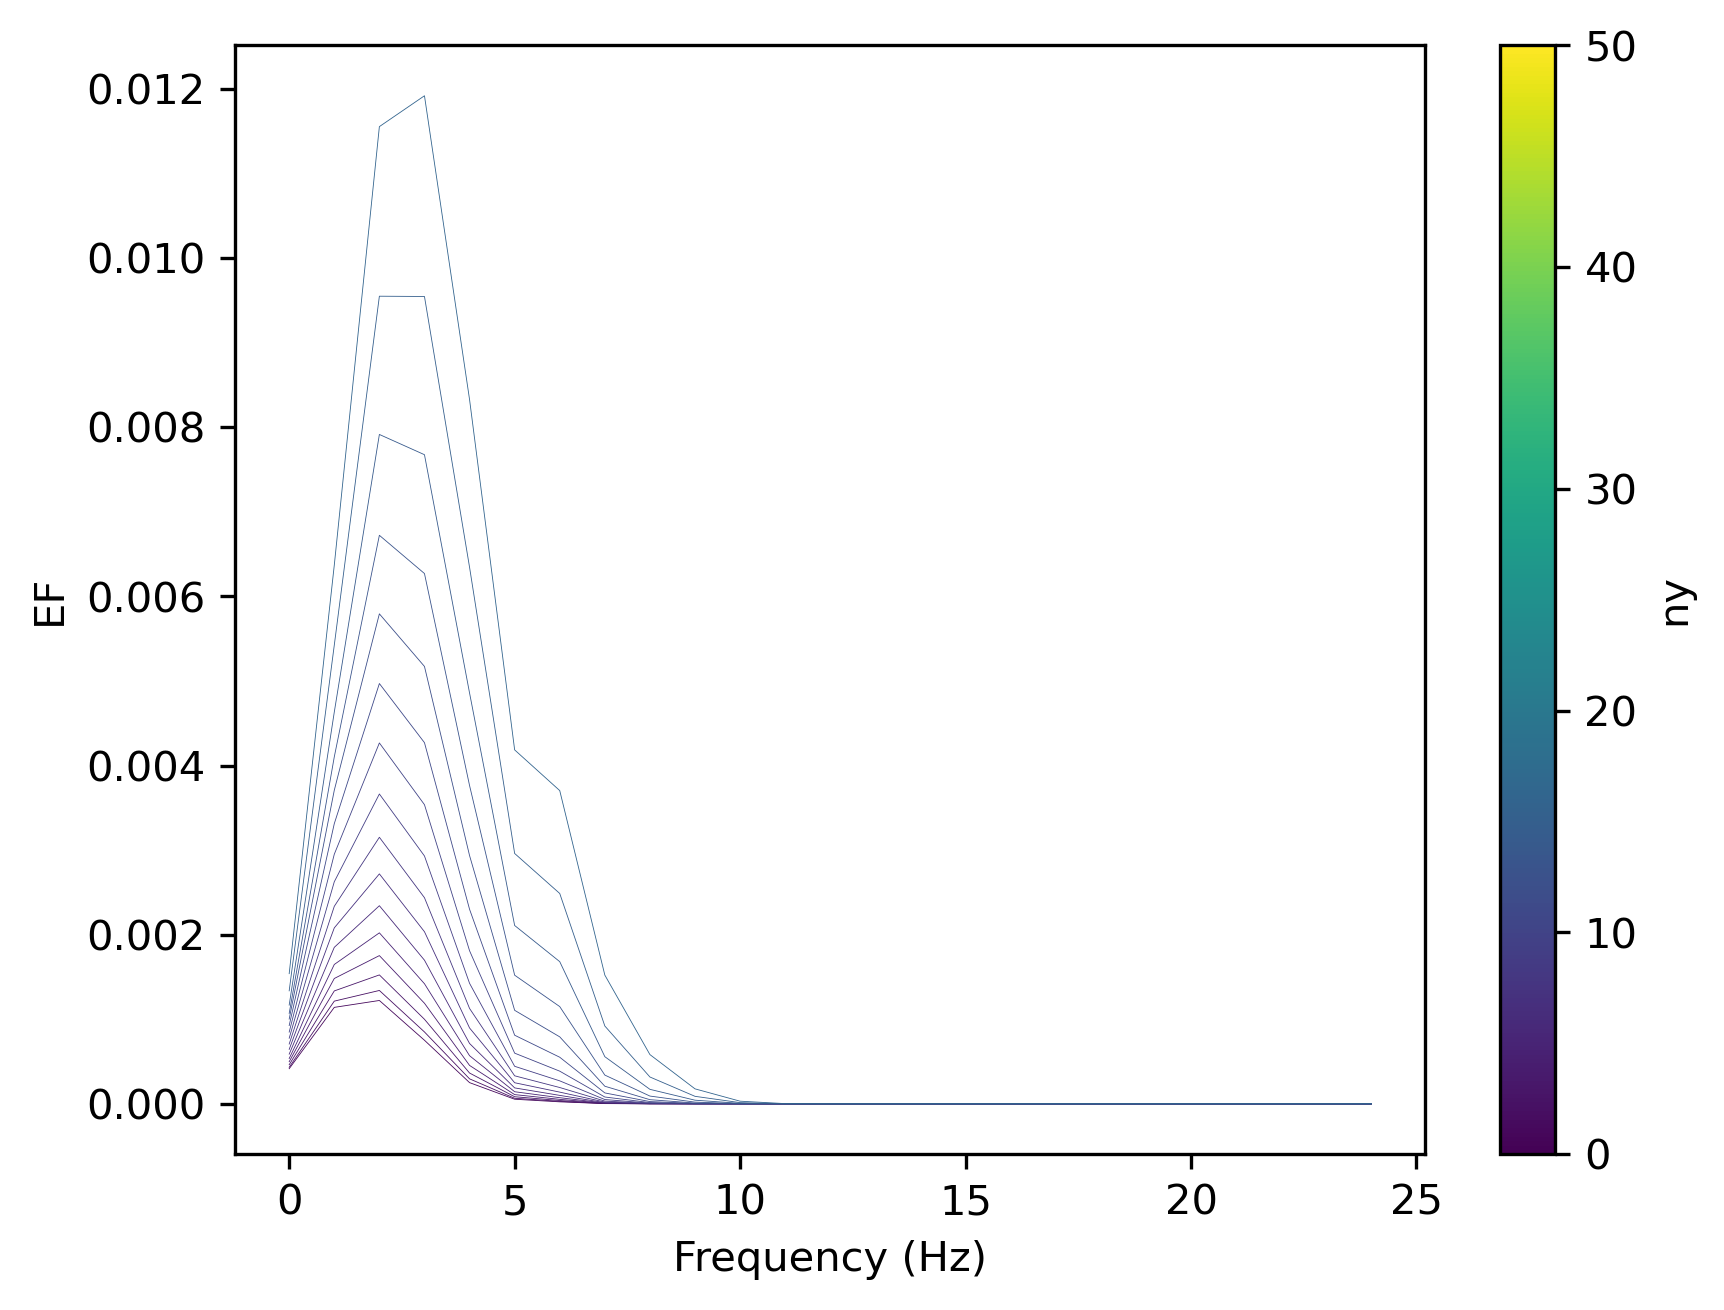

In [67]:

# Example data
EF = ds_waves_in_ice['EF']        # shape: (nfreq, nx)
freqs = ds_waves_in_ice['freq'].values
xcoord = distance_into_ice  # or whatever the x-dim is

# Choose a colormap
cmap = plt.cm.viridis

# Normalize frequencies for the colormap
norm = plt.Normalize(vmin=ds_waves_in_ice.ny.values.min(), vmax=50)

fig, ax = plt.subplots()
counter = 0
# Plot each frequency with its corresponding colour
for i in ds_waves_in_ice.ny.values:
    if not np.isnan(ds_waves_in_ice['EF'].isel(ny=i).values).all():
        ax.plot(freqs, ds_waves_in_ice['EF'].isel(ny=i), color=cmap(norm(i)), lw=0.2)  # or line segments if you have x–y curves 
        # /ds_waves_in_ice['EF'].isel(ny=i).max()
        counter += 1
        if counter > 15:
            break

# If EF has a second dimension (nfreq × nx), use:
# for i, f in enumerate(freqs):
#     ax.plot(x, EF[i, :], color=cmap(norm(f)))

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])     # required for older matplotlib versions
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("ny")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("EF")

plt.show()

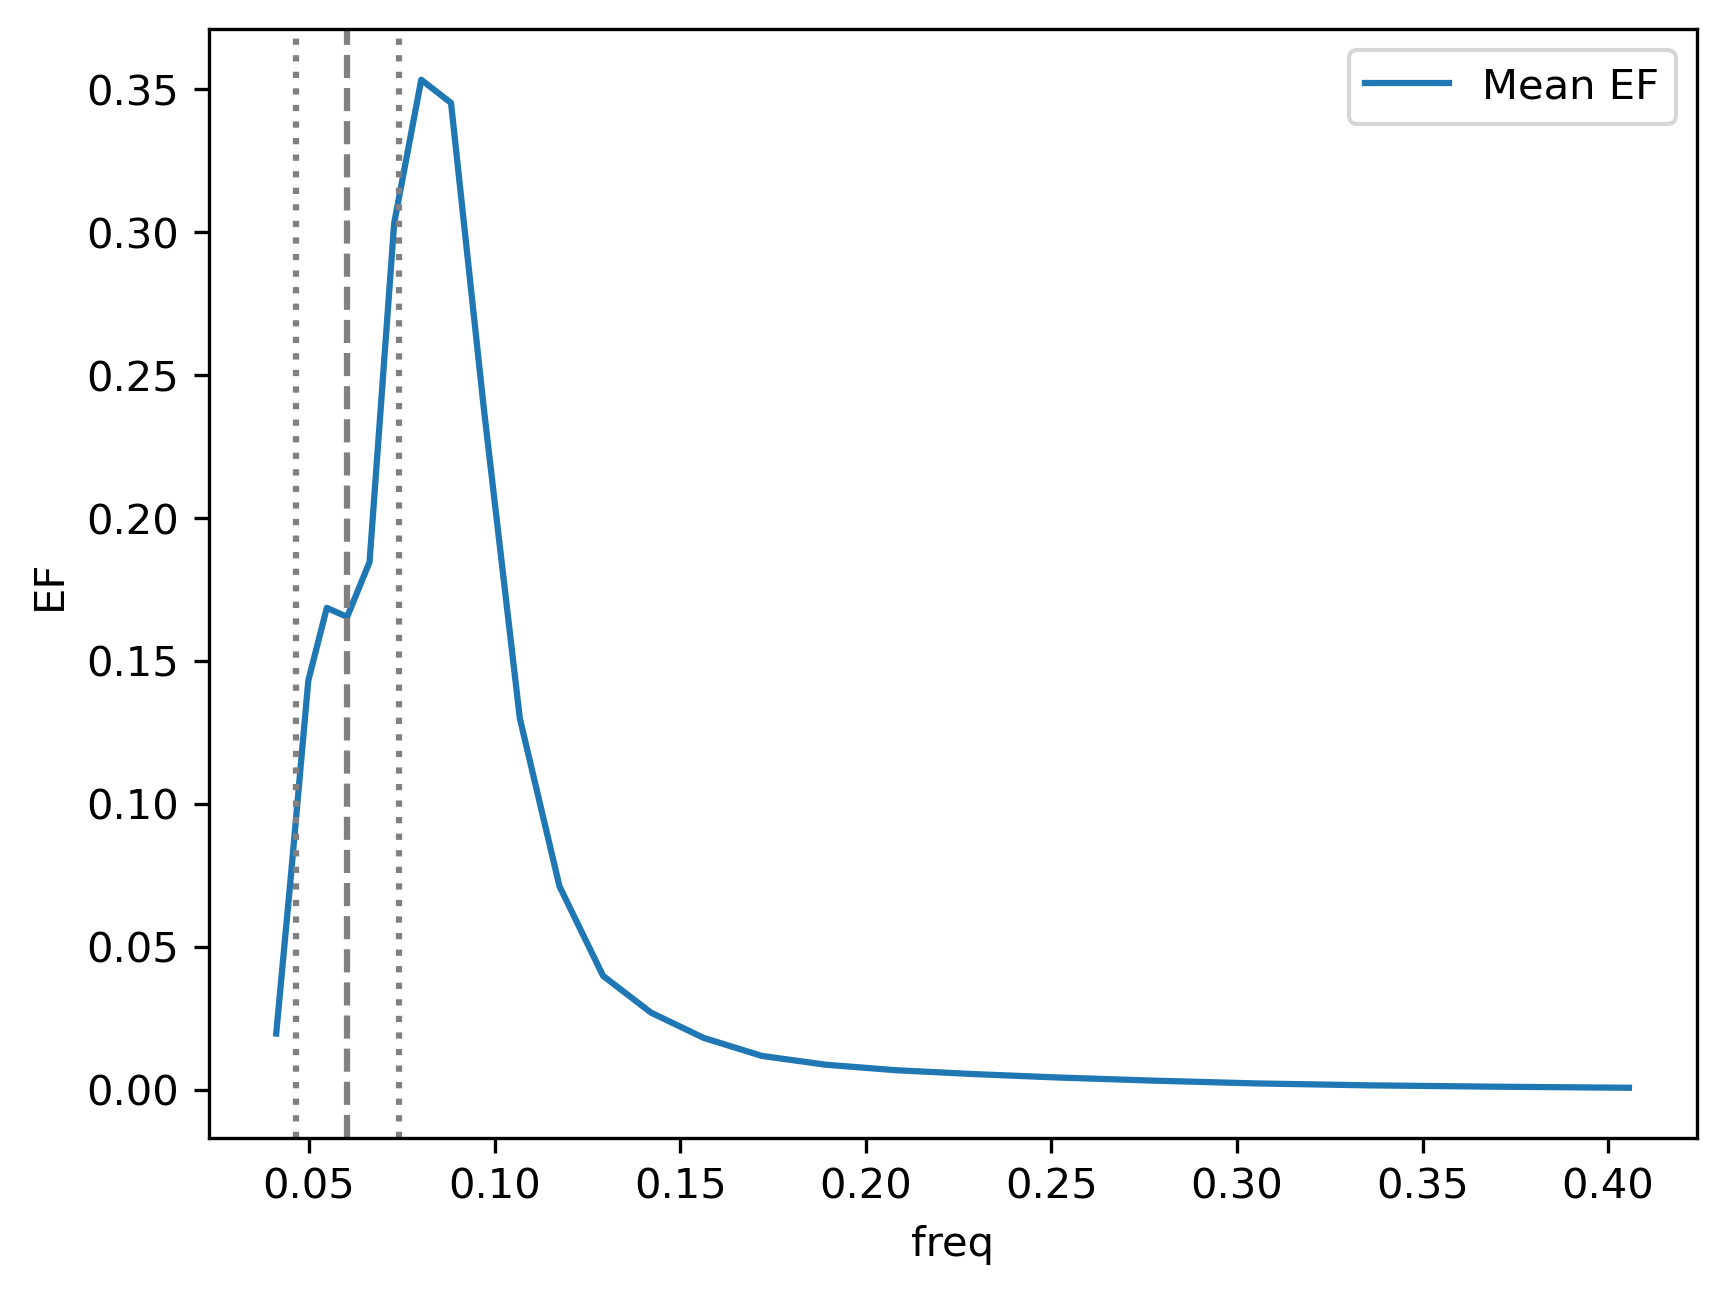

In [81]:
import matplotlib.pyplot as plt

meanEF = (ds_waves_in_ice['EF']/ds_waves_in_ice['HS']).mean(dim='ny')
stdEF  = ds_waves_in_ice['EF'].std(dim='ny')

x = meanEF[meanEF.dims[0]]  # auto-detect the x-axis (freq or distance)
freqs, periods = get_ww3_freqs(nk=25)

fig, ax = plt.subplots()

# Mean line
ax.plot(freqs, meanEF, label='Mean EF')

# Shaded region (mean ± std)
# ax.fill_between(
#     x,
#     meanEF - stdEF,
#     meanEF + stdEF,
#     alpha=0.3,
#     color='gray',
#     label='±1 std'
# )

ax.axvline(ds_waves_in_ice['FP0'].mean(), linestyle='--', color='gray')
ax.axvline(ds_waves_in_ice['FP0'].mean()-ds_waves_in_ice['FP0'].std(), linestyle=':', color='gray')
ax.axvline(ds_waves_in_ice['FP0'].mean()+ds_waves_in_ice['FP0'].std(), linestyle=':', color='gray')

ax.set_xlabel(x.name)
ax.set_ylabel('EF')
ax.legend()
plt.show()

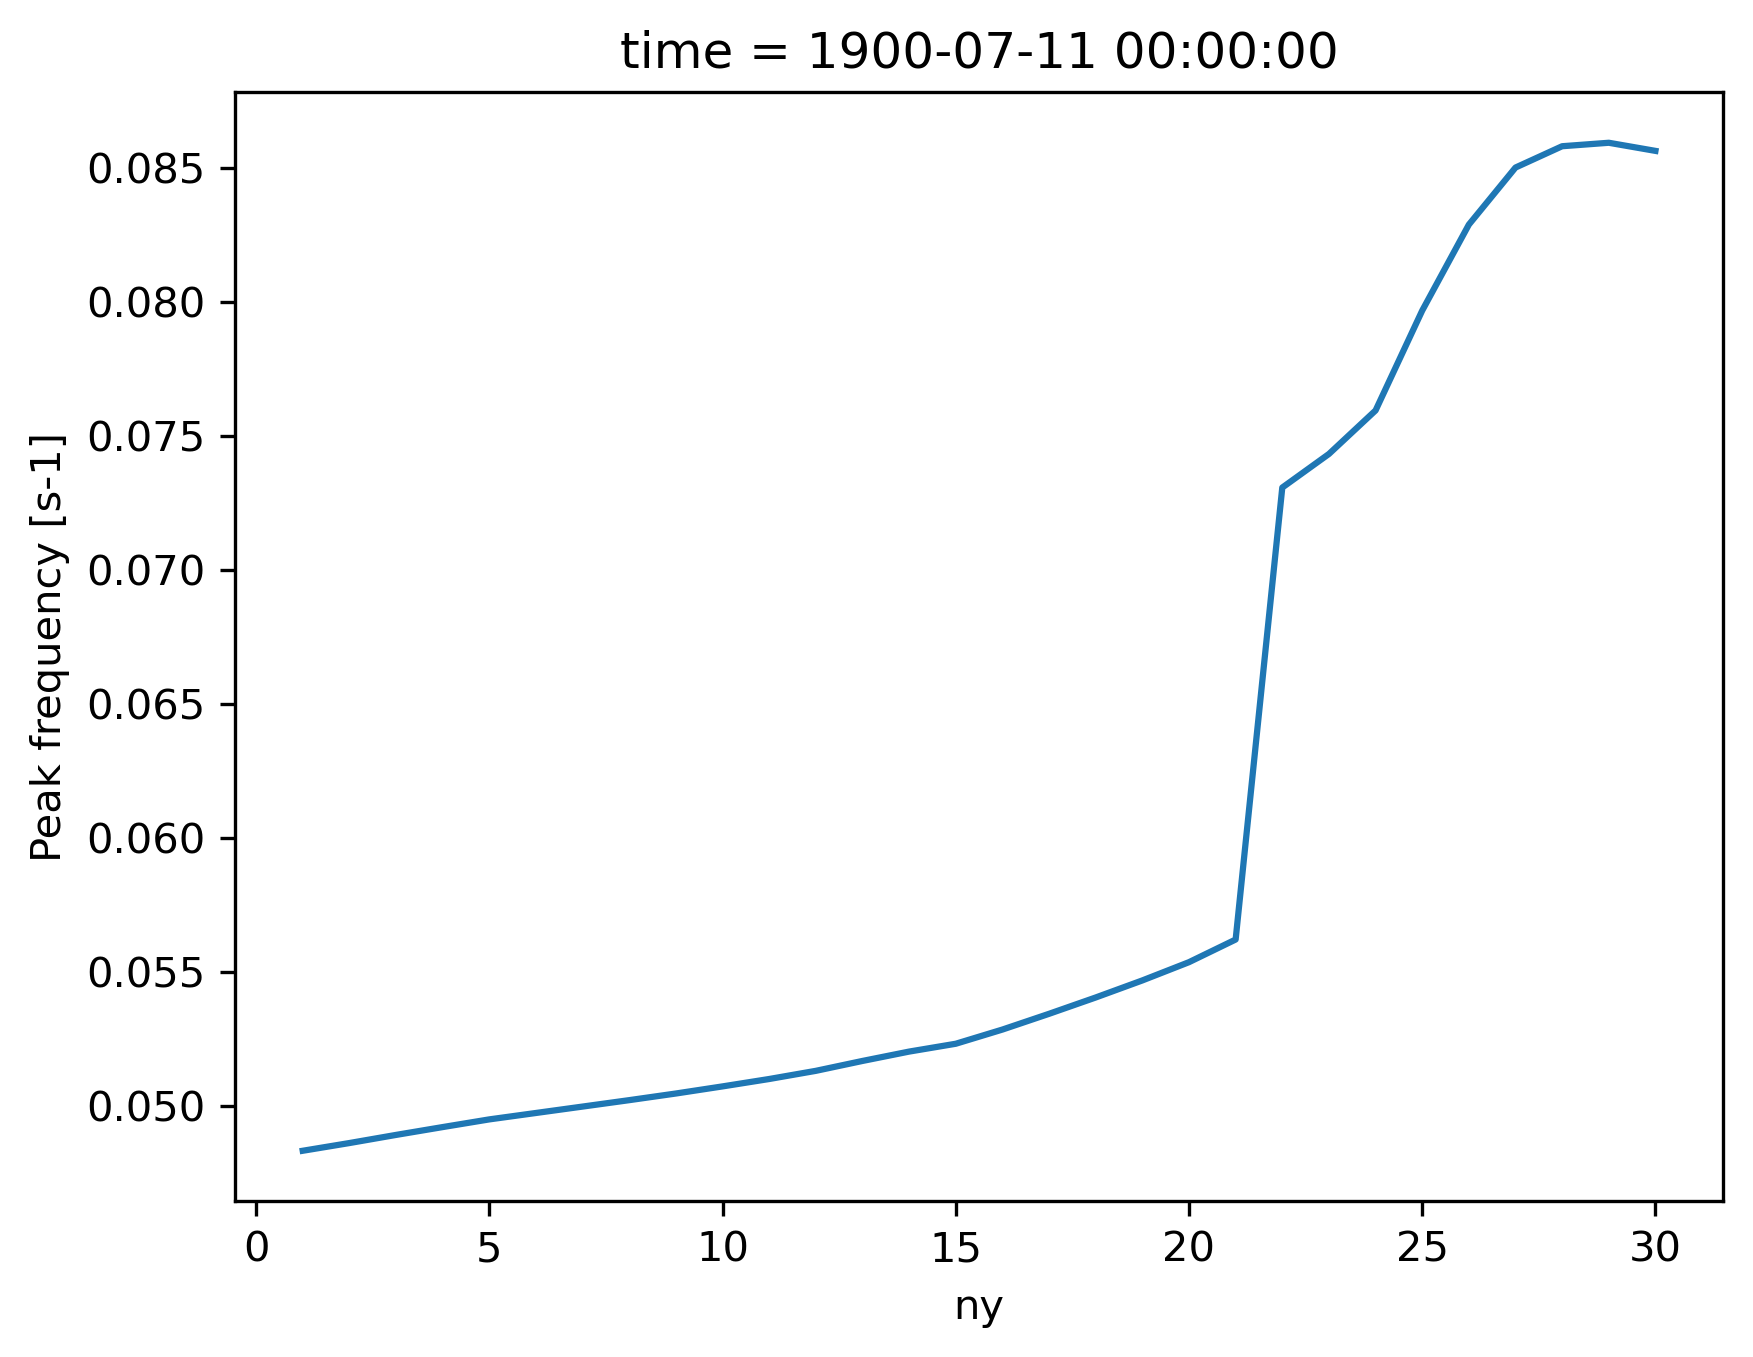

In [75]:
ds_waves_in_ice['FP0'].plot()

### Load monthly sea surface height (`zos`) and plot the field at the last available time

In [7]:
zos = datastore.search(variable="zos", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

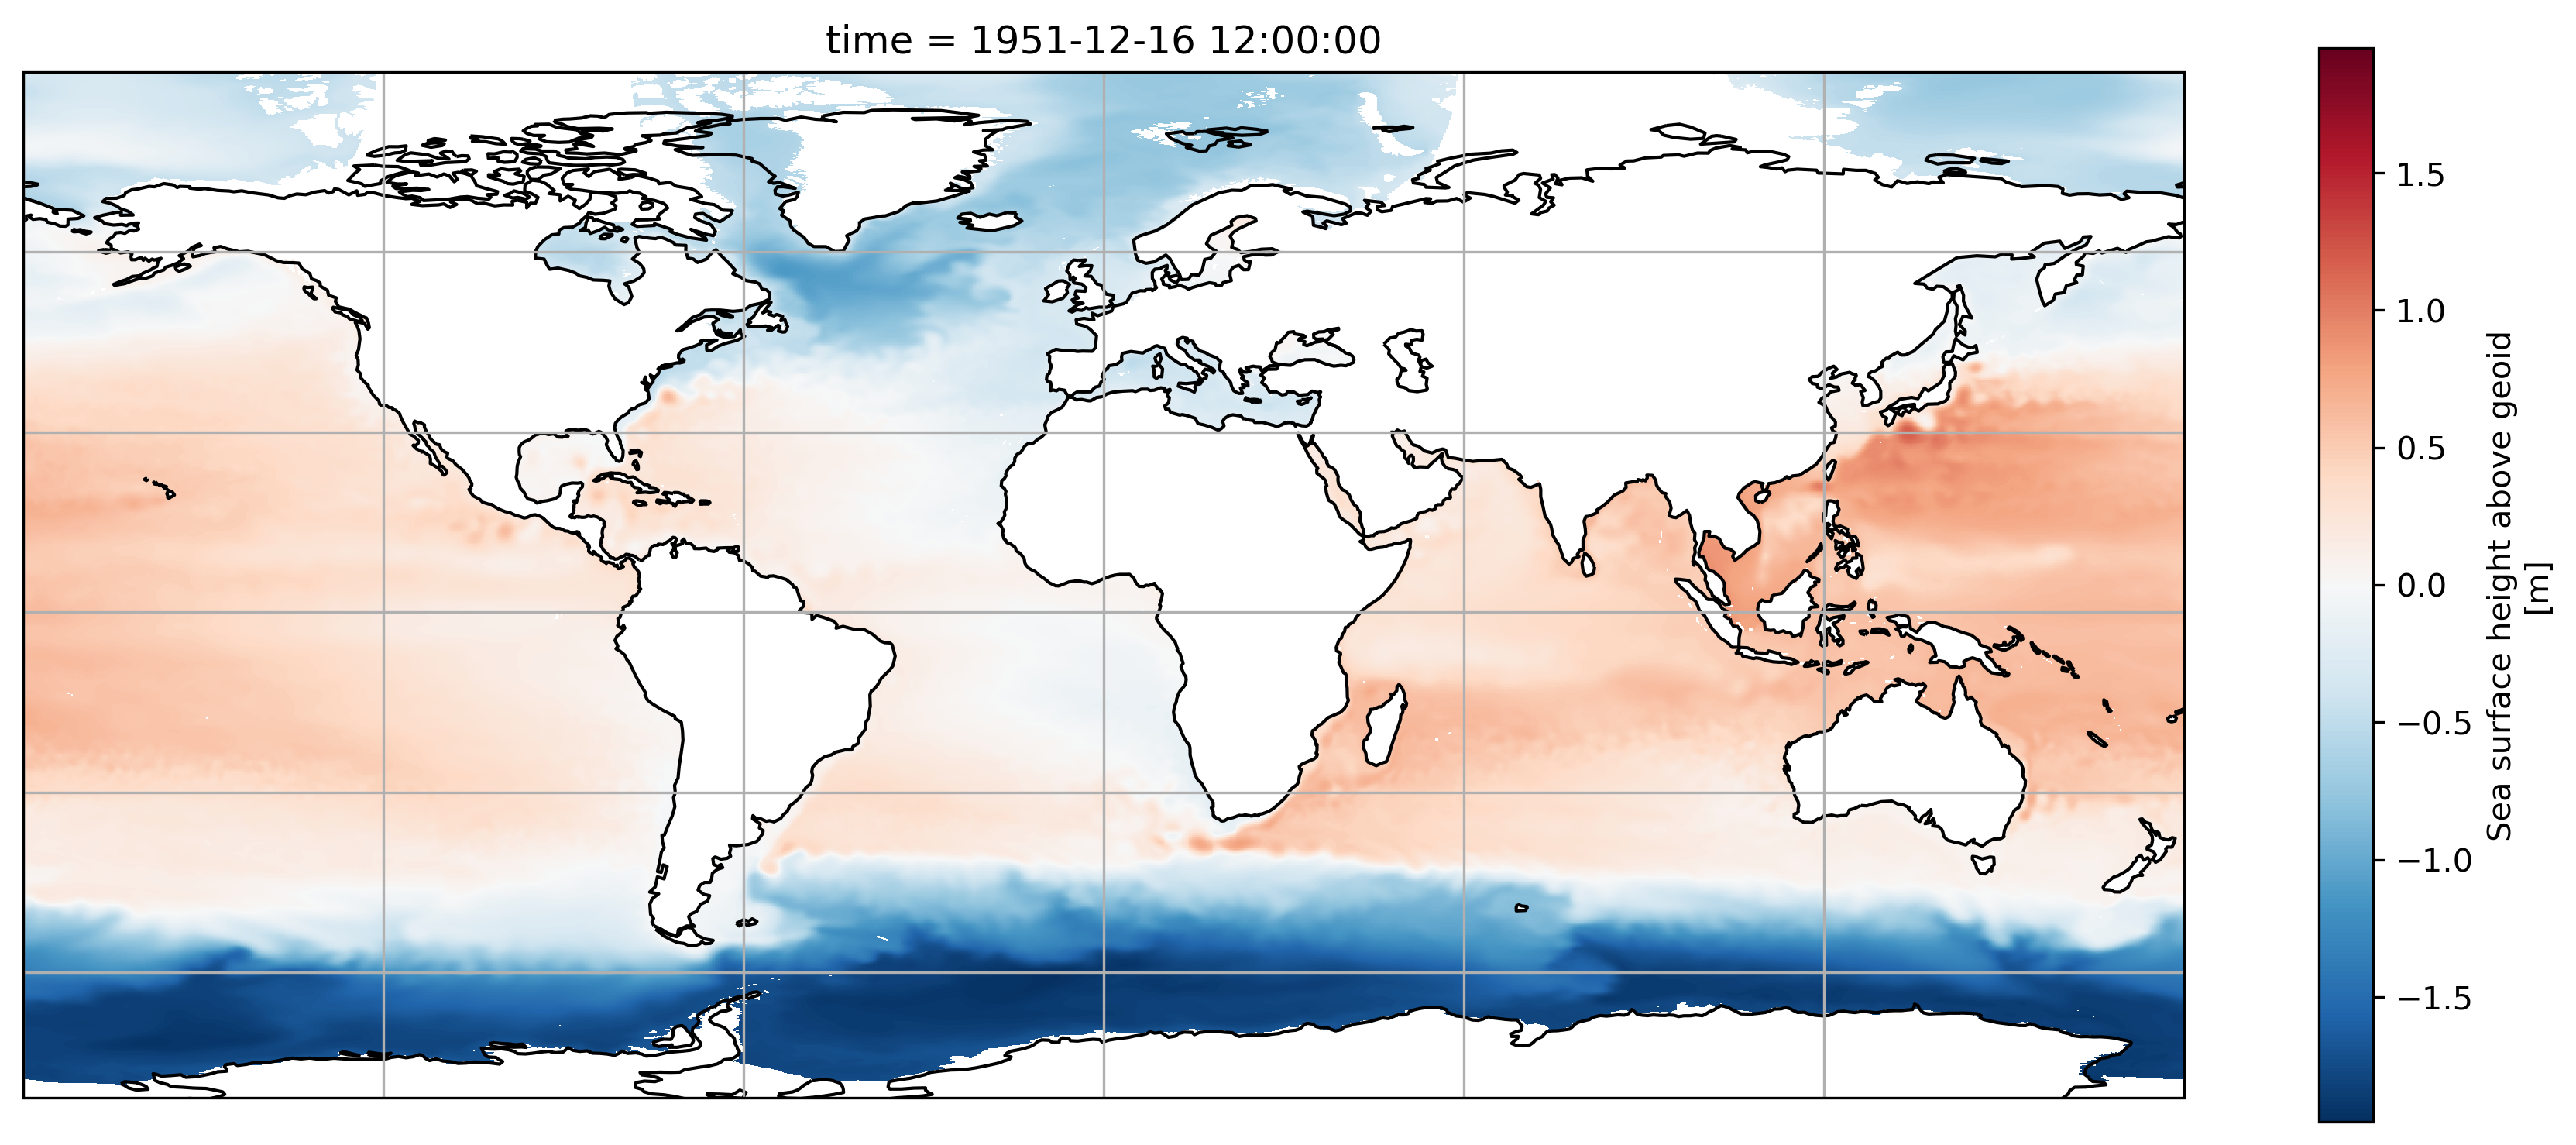

In [8]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

#### Fixing the plot axes

Notice that the white land-masked regions are distorted away from the coastlines in the Arctic in the above plot. This is because a tripolar grid is used, so the grid lines are not zonal and meridional north of 65N, and consequently the nominal 1D coordinates `xh` and `yh` are incorrect. To fix this we need to use 2d coordinates `geolon` and `geolat`.

We can get these coorindates from the intake-esm datastore. However, note that `geolon` and `geolat` contain NaNs in regions where processors were masked over land. Below we replace these NaNs with zeros so that the coordinates can be used for plotting.

In [9]:
coords = datastore.search(variable=["geolat", "geolon"]).to_dask().compute()
coords = coords.fillna(0.0)

zos = zos.assign_coords(coords)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [ ]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax, x="geolon", y="geolat")

ax.coastlines()
_ = ax.gridlines()
plt.savefig(plotfolder+'exampleout.png')

In [ ]:
client.close()